In [1]:
#SigKernelTrials3
import apache_beam

In [2]:
import os
import weatherbench2
import xarray as xr
import math
from weatherbench2.regions import SliceRegion, ExtraTropicalRegion
from weatherbench2.evaluation import evaluate_in_memory
from weatherbench2 import config
import numpy as np
import sigkernel
import torch
from einops import rearrange
from itertools import product
import cython
import matplotlib.pyplot  as plt
import tqdm

In [3]:
forecast_path = 'gs://weatherbench2/datasets/ifs_ens/2018-2022-64x32_equiangular_conservative.zarr'
obs_path = 'gs://weatherbench2/datasets/era5/1959-2022-6h-64x32_equiangular_conservative.zarr'
forecasts = xr.open_zarr(forecast_path)
observations = xr.open_zarr(obs_path)

In [4]:
forecasts

<xarray.Dataset>
Dimensions:                   (time: 3652, number: 50,
                               prediction_timedelta: 61, longitude: 64,
                               latitude: 32, level: 3)
Coordinates:
  * latitude                  (latitude) float64 -87.19 -81.56 ... 81.56 87.19
  * level                     (level) int32 500 700 850
  * longitude                 (longitude) float64 0.0 5.625 ... 348.8 354.4
  * number                    (number) int32 1 2 3 4 5 6 7 ... 45 46 47 48 49 50
  * prediction_timedelta      (prediction_timedelta) timedelta64[ns] 00:00:00...
  * time                      (time) datetime64[ns] 2018-01-01 ... 2022-12-31...
Data variables: (12/15)
    10m_u_component_of_wind   (time, number, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 50, 1, 64, 32), meta=np.ndarray>
    10m_v_component_of_wind   (time, number, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 50, 1, 64, 32), meta=np.ndarray>
    10m_wind_speed            (time, number, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 50, 1, 64, 32), meta=np.ndarray>
    2m_temperature            (time, number, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 50, 1, 64, 32), meta=np.ndarray>
    geopotential              (time, number, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 50, 1, 3, 64, 32), meta=np.ndarray>
    mean_sea_level_pressure   (time, number, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 50, 1, 64, 32), meta=np.ndarray>
    ...                        ...
    total_precipitation       (time, number, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 50, 1, 64, 32), meta=np.ndarray>
    total_precipitation_24hr  (time, number, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 50, 1, 64, 32), meta=np.ndarray>
    total_precipitation_6hr   (time, number, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 50, 1, 64, 32), meta=np.ndarray>
    u_component_of_wind       (time, number, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 50, 1, 3, 64, 32), meta=np.ndarray>
    v_component_of_wind       (time, number, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 50, 1, 3, 64, 32), meta=np.ndarray>
    wind_speed                (time, number, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 50, 1, 3, 64, 32), meta=np.ndarray>

In [7]:
forecastssel = forecasts['temperature'].sel(level = 500, time = slice('2020-01-01', '2020-01-10'))
forecasts0 = forecastssel[:,:,:,:,:]
savedfor = forecasts0.values

observationsel = observations['temperature'].sel(level = 500, time = slice('2020-01-01', '2020-01-25')) #Plus 15 days
savedobs = observationsel.values
#1 month forecasts (1.5 obs) takes 1m9

In [ ]:
savedobsshift = savedobs 
savedforshift = savedfor 

fors = savedforshift[:,:,0,:,:]
obs = savedobsshift[0:0-60,:,:][::2,:,:]

obs = obs.reshape(-1,64*32)
obs = np.cumsum(obs,axis=0)

fors = fors.reshape(20,50,64*32)
fors = np.cumsum(fors,axis=0)

obs = np.expand_dims(obs, axis = 0)
fors = np.transpose(fors, (1,0,2)) #some 

llobs = sigkernel.transform(obs, scale = 1, at = True, ll = True)
llfors = sigkernel.transform(fors, scale = 1, at = True, ll = True)

X = torch.tensor(llfors, dtype=torch.double)
y = torch.tensor(llobs, dtype=torch.double)

print(X.shape)
print(y.shape)

In [9]:
kernelscores = [[],[]]
print(kernelscores)
kernelscores[0].append(5)
kernelscores

[[], []]


[[5], []]

In [20]:
savedobs[::4].shape[0]

25

In [8]:
def findscale(obs,fors):
    maxvalue = np.array([obs.max(),fors.max()]).max()
    days = obs[::4].shape[0]

    return maxvalue*days


In [13]:
def kernelscoresfunc(observations,forcasts,sigma):
    kernelscores = []
    scale = findscale(observations, forcasts)/100
    static_kernel = sigkernel.RBFKernel(sigma=sigma)
    dyadic_order = 2
    signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order)
    time = forcasts.shape[0]

    #think about removing culmative
    for i in range(60): #60
            fors = forcasts[:,:,i,:,:]
            obs = observations[i:i-60,:,:][::2,:,:]

            obs = obs.reshape(-1,64*32)
            obs = np.cumsum(obs,axis=0)

            fors = fors.reshape(time,50,64*32)
            fors = np.cumsum(fors,axis=0)

            obs = np.expand_dims(obs, axis = 0)
            fors = np.transpose(fors, (1,0,2))

            llobs = sigkernel.transform(obs, scale = 1/scale, at = True, ll = True)
            llfors = sigkernel.transform(fors, scale = 1/scale, at = True, ll = True)

            X = torch.tensor(llfors, dtype=torch.double)
            y = torch.tensor(llobs, dtype=torch.double)

            val = signature_kernel.compute_scoring_rule(X,y).item()
            print(val)
            kernelscores.append(val)


In [16]:
kernelscores = [[],[],[],[],[],[]]
#Non weighted
#61 predictlags, just doing 60

scale = findscale(savedobs, savedfor)/10

j =-1 
for sigma in [10]: # 5e-2, 1e-1, 2.5e-1, 5e-1, 7.5e-1, 1.]:
        j+=1 
        static_kernel = sigkernel.RBFKernel(sigma=sigma)
        dyadic_order = 2
        signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order)

        #think about removing culmative
        for i in range(60): #60
                fors = savedfor[:,:,i,:,:]
                obs = savedobs[i:i-60,:,:][::2,:,:]

                obs = obs.reshape(-1,64*32)
                obs = np.cumsum(obs,axis=0)

                fors = fors.reshape(20,50,64*32)
                fors = np.cumsum(fors,axis=0)

                obs = np.expand_dims(obs, axis = 0)
                fors = np.transpose(fors, (1,0,2))

                llobs = sigkernel.transform(obs, scale = 1/scale, at = True, ll = True)
                llfors = sigkernel.transform(fors, scale = 1/scale, at = True, ll = True)

                X = torch.tensor(llfors, dtype=torch.double)
                y = torch.tensor(llobs, dtype=torch.double)

                val = signature_kernel.compute_scoring_rule(X,y).item()
                print(val)
                kernelscores[j].append(val)

-7630400800.081623
-7951060171.299084
-7640215992.877666
-7635372776.768089
-7089622847.755657
-7029107654.282514
-6366659360.133453
-6275168455.2982645
-5501812110.207754
-5269557468.18573
-4437995941.745704
-4087633755.459326
-3292196688.550967
-2821647171.524559
-2055243598.7878923
-1636228216.2987785
-1044737631.1808562
-671244994.3084197
-281109642.6910801
14458873.25438404
243674276.79884624
447222866.9646313
589620822.2807362
670058050.5393072
701751050.676161
694042509.7204443
671677430.0827113
633570719.243686
592731146.4461594
543550421.3075085
495367577.36410546
446084079.0570946
399401047.21127665
356499017.96755266
317033804.58053935
282717591.4047767
254130309.72511622
228823354.34006765
205893034.78570107
185392502.39442325
166986963.67751095
150736798.21097073
137491442.87063265
125887462.65740618
114420128.89842427
103162957.68248682
92576914.60721564
84284964.53252617
77014857.9723307
70187970.36822261
64396867.24756718
59021076.40264452
54767928.9214401
50854135.7441

In [17]:
kernelscores

[[-7630400800.081623,
  -7951060171.299084,
  -7640215992.877666,
  -7635372776.768089,
  -7089622847.755657,
  -7029107654.282514,
  -6366659360.133453,
  -6275168455.2982645,
  -5501812110.207754,
  -5269557468.18573,
  -4437995941.745704,
  -4087633755.459326,
  -3292196688.550967,
  -2821647171.524559,
  -2055243598.7878923,
  -1636228216.2987785,
  -1044737631.1808562,
  -671244994.3084197,
  -281109642.6910801,
  14458873.25438404,
  243674276.79884624,
  447222866.9646313,
  589620822.2807362,
  670058050.5393072,
  701751050.676161,
  694042509.7204443,
  671677430.0827113,
  633570719.243686,
  592731146.4461594,
  543550421.3075085,
  495367577.36410546,
  446084079.0570946,
  399401047.21127665,
  356499017.96755266,
  317033804.58053935,
  282717591.4047767,
  254130309.72511622,
  228823354.34006765,
  205893034.78570107,
  185392502.39442325,
  166986963.67751095,
  150736798.21097073,
  137491442.87063265,
  125887462.65740618,
  114420128.89842427,
  103162957.68248682,

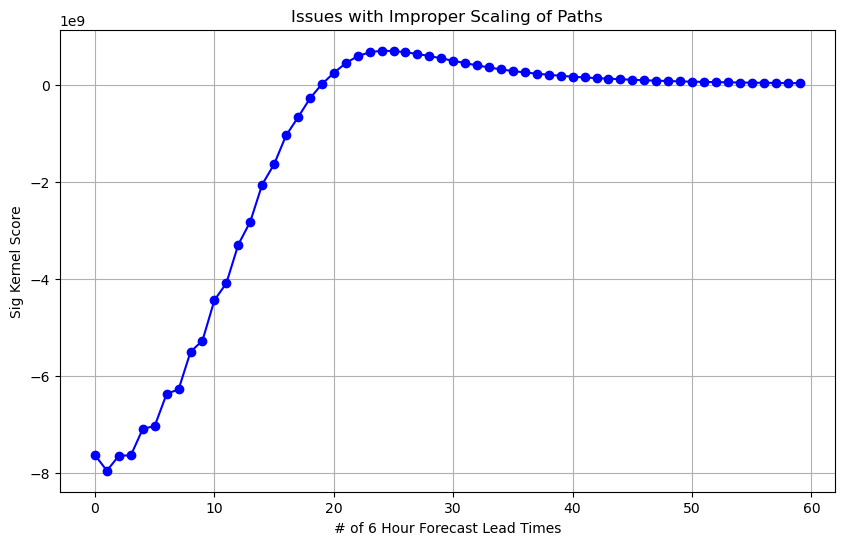

In [19]:
test1 = kernelscores[0]
#Sigma 1, Dyadic Order 2, CumSum, Lead Lagged, shift, Not Lat weighted 

plt.figure(figsize=(10, 6))  # Set the figure size if needed
plt.plot(test1, marker='o', linestyle='-', color='b')  # Plot with line and marker
plt.title("Issues with Improper Scaling of Paths")
plt.xlabel("# of 6 Hour Forecast Lead Times")
plt.ylabel("Sig Kernel Score")
plt.grid(True)  # Optional: add a grid for better readability
plt.show()

In [41]:
static_kernel = sigkernel.RBFKernel(sigma=1)
static_kernel.batch_kernel(X,X)

tensor([[[1.0000, 0.0636, 0.0040,  ..., 0.0000, 0.0000, 0.0000],
         [0.0636, 1.0000, 0.0636,  ..., 0.0000, 0.0000, 0.0000],
         [0.0040, 0.0636, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 1.0000, 0.0634, 0.0040],
         [0.0000, 0.0000, 0.0000,  ..., 0.0634, 1.0000, 0.0634],
         [0.0000, 0.0000, 0.0000,  ..., 0.0040, 0.0634, 1.0000]],

        [[1.0000, 0.0639, 0.0041,  ..., 0.0000, 0.0000, 0.0000],
         [0.0639, 1.0000, 0.0639,  ..., 0.0000, 0.0000, 0.0000],
         [0.0041, 0.0639, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 1.0000, 0.0638, 0.0041],
         [0.0000, 0.0000, 0.0000,  ..., 0.0638, 1.0000, 0.0638],
         [0.0000, 0.0000, 0.0000,  ..., 0.0041, 0.0638, 1.0000]],

        [[1.0000, 0.0636, 0.0040,  ..., 0.0000, 0.0000, 0.0000],
         [0.0636, 1.0000, 0.0636,  ..., 0.0000, 0.0000, 0.0000],
         [0.0040, 0.0636, 1.0000,  ..., 0.0000, 0.0000, 0.

In [45]:
latitude = forecasts['latitude'][:].values
delta = 2.8125
theta_upper = latitude + delta
theta_lower = latitude - delta

# Calculate weights based on the provided formula
weights = (np.sin(np.radians(theta_upper)) - np.sin(np.radians(theta_lower)))
weights /= weights.sum()
weights *= 32

array([0.07704437, 0.23039114, 0.38151911, 0.52897285, 0.67133229,
       0.80722643, 0.93534654, 1.05445875, 1.16341595, 1.26116882,
       1.34677594, 1.41941287, 1.47838008, 1.52310968, 1.55317091,
       1.56827425, 1.56827425, 1.55317091, 1.52310968, 1.47838008,
       1.41941287, 1.34677594, 1.26116882, 1.16341595, 1.05445875,
       0.93534654, 0.80722643, 0.67133229, 0.52897285, 0.38151911,
       0.23039114, 0.07704437])

In [46]:
savedfor[:,:,0,:,:].shape
savedobs[0:0-60,:,:][::2,:,:].shape

(20, 64, 32)

In [47]:
kernelscorespreweighted = []
#Non weighted
#61 predictlags, just doing 60

scale = findscale(savedobs, savedfor)

for sigma in [1]:
        static_kernel = sigkernel.RBFKernel(sigma=sigma)
        dyadic_order = 2
        signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order)

        #think about removing culmative
        for i in range(60): #60
                fors = savedfor[:,:,i,:,:] * weights[None,None,None,:]
                obs = savedobs[i:i-60,:,:][::2,:,:] * weights[None,None,:]

                obs = obs.reshape(-1,64*32)
                obs = np.cumsum(obs,axis=0)

                fors = fors.reshape(20,50,64*32)
                fors = np.cumsum(fors,axis=0)

                obs = np.expand_dims(obs, axis = 0)
                fors = np.transpose(fors, (1,0,2))

                llobs = sigkernel.transform(obs, scale = 1/scale, at = True, ll = True)
                llfors = sigkernel.transform(fors, scale = 1/scale, at = True, ll = True)

                X = torch.tensor(llfors, dtype=torch.double)
                y = torch.tensor(llobs, dtype=torch.double)

                val = signature_kernel.compute_scoring_rule(X,y).item()
                print(val)
                kernelscores[j].append(val)

-8193241867.409168
-8259738218.107984
-8240026604.715238
-8231405834.247752
-8186331387.9870205
-8173539121.967029
-8117534795.900328
-8105712008.816706
-8019432871.128912
-7981531375.594784
-7882021581.609418
-7824386543.177368
-7720178045.887436
-7632307943.57678
-7504035124.776953
-7398941393.414636
-7241642182.009205
-7095947161.545069
-6923229537.966781
-6752424073.614063
-6578122440.995812
-6393465458.626517
-6173031104.893814
-5956859869.898056
-5716180436.812103
-5523009329.145723
-5271339514.798563
-5071657069.332206
-4789796290.876795
-4528904870.334688
-4195749929.6530743
-3899673160.8984756
-3573706690.9130497
-3282488148.5684423
-2960410019.6971054
-2684063244.0979824
-2375526679.1635723
-2130920402.896514
-1871968575.9567957
-1680320917.3409433
-1454728799.1378536
-1284771190.087781
-1092651613.376752
-958204857.6031694
-783244319.48458
-650835834.156456
-483310957.4104719
-365737760.21044445
-192959894.89073277
-76569609.75706005
83739074.88103962
160079756.9203596
26883

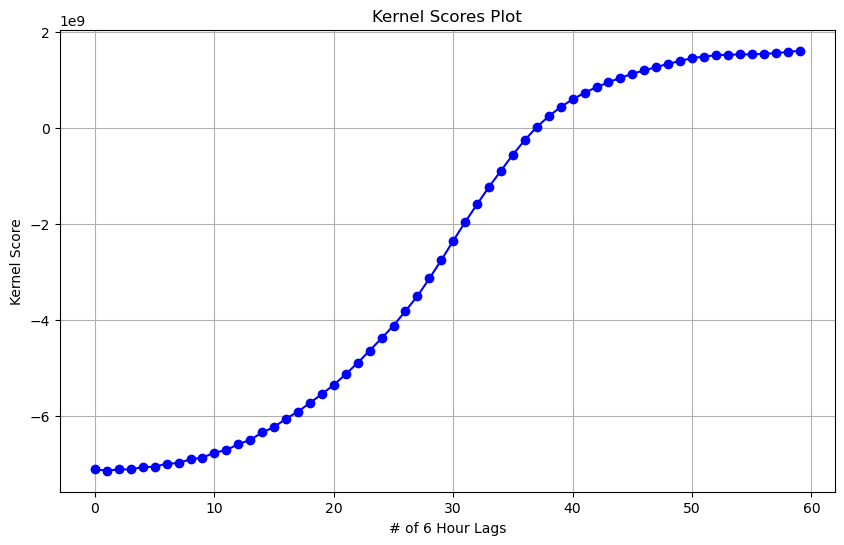

In [65]:
test2 = kernelscores[0][:-60]
#Sigma 1, Dyadic Order 2, CumSum, Lead Lagged, shift, pre Lat weighted 

#Plotting both non lat weighted, prelat weighted
plt.figure(figsize=(10, 6))  # Set the figure size if needed
plt.plot(test2, marker='o', linestyle='-', color='b')  # Plot with line and marker
plt.title("Kernel Scores Plot")
plt.xlabel("# of 6 Hour Lags")
plt.ylabel("Kernel Score")
plt.grid(True)  # Optional: add a grid for better readability
plt.show()

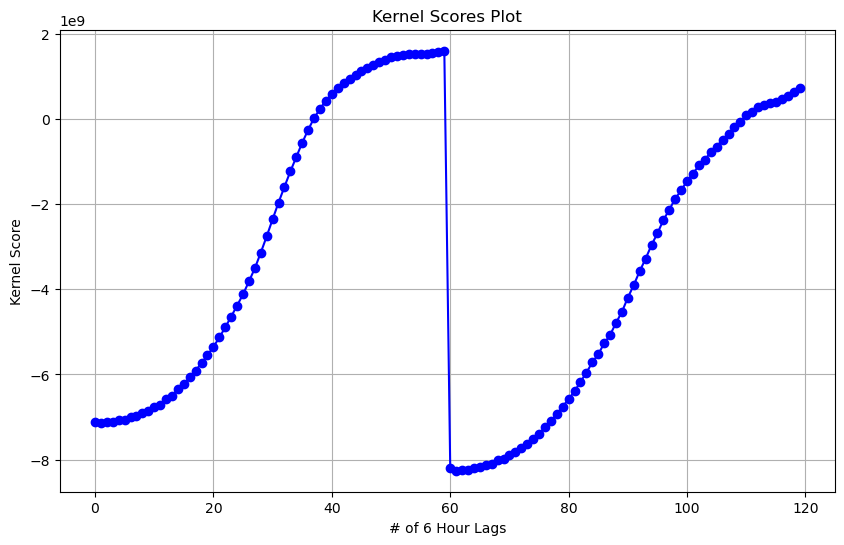

In [ ]:
test2 = kernelscores[0] # kernelscores[0][:-60]
#Sigma 1, Dyadic Order 2, CumSum, Lead Lagged, shift, pre Lat weighted 

#Plotting both non lat weighted, prelat weighted
plt.figure(figsize=(10, 6))  # Set the figure size if needed
plt.plot(test2, marker='o', linestyle='-', color='b')  # Plot with line and marker
plt.title("Kernel Scores Plot")
plt.xlabel("# of 6 Hour Lags")
plt.ylabel("Kernel Score")
plt.grid(True)  # Optional: add a grid for better readability
plt.show()

In [ ]:
kernelscores[0][:-60]

60

(64, 50, 61, 64, 32)

In [19]:
kernelscoresfunc(savedobs, savedfor, sigma=1)
#40 seconds to get a result.

-6.03989348275374e+25
-6.181698620011384e+25
-6.006588740452291e+25
-6.03716146869132e+25
-5.763115533539776e+25
-5.810309458795927e+25
-5.520472262806266e+25
-5.572735699250273e+25
-5.237855188624683e+25
-5.264184662818817e+25
-4.898390865033379e+25
-4.9059872716677895e+25
-4.535926059745569e+25
-4.4895736019687974e+25
-4.062858500596657e+25
-3.967045506718887e+25
-3.511970147410466e+25
-3.3312675209875177e+25
-2.8810585790966024e+25
-2.667072553240363e+25
-2.244656594441657e+25
-2.0209493584236057e+25
-1.602663553517175e+25
-1.3570160876201162e+25
-9.544954325302294e+24
-7.133591145280673e+24
-3.3867600975068064e+24
-1.0605981443609683e+24
2.3428316257301817e+24
4.391612944185975e+24
7.010275519507983e+24
8.42363420234305e+24
1.0284795880420484e+25
1.1236350787334739e+25
1.2688684411939173e+25
1.3499904702273379e+25
1.4654140024127002e+25
1.5163902485283042e+25
1.5752610080152238e+25
1.5830998566592067e+25
1.6040713150512136e+25


KeyboardInterrupt: 

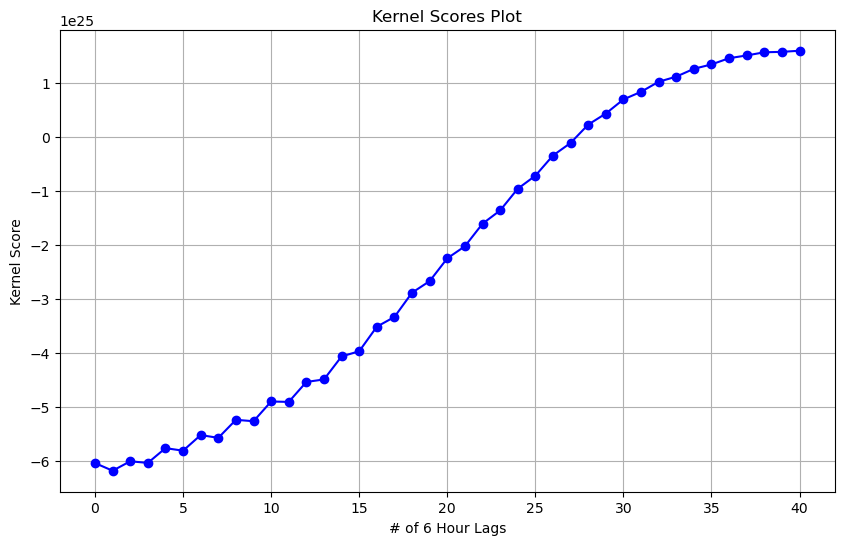

In [20]:
array = [
    -6.03989348275374e+25, -6.181698620011384e+25, -6.006588740452291e+25, -6.03716146869132e+25,
    -5.763115533539776e+25, -5.810309458795927e+25, -5.520472262806266e+25, -5.572735699250273e+25,
    -5.237855188624683e+25, -5.264184662818817e+25, -4.898390865033379e+25, -4.9059872716677895e+25,
    -4.535926059745569e+25, -4.4895736019687974e+25, -4.062858500596657e+25, -3.967045506718887e+25,
    -3.511970147410466e+25, -3.3312675209875177e+25, -2.8810585790966024e+25, -2.667072553240363e+25,
    -2.244656594441657e+25, -2.0209493584236057e+25, -1.602663553517175e+25, -1.3570160876201162e+25,
    -9.544954325302294e+24, -7.133591145280673e+24, -3.3867600975068064e+24, -1.0605981443609683e+24,
    2.3428316257301817e+24, 4.391612944185975e+24, 7.010275519507983e+24, 8.42363420234305e+24,
    1.0284795880420484e+25, 1.1236350787334739e+25, 1.2688684411939173e+25, 1.3499904702273379e+25,
    1.4654140024127002e+25, 1.5163902485283042e+25, 1.5752610080152238e+25, 1.5830998566592067e+25, 1.6040713150512136e+25
]

plt.figure(figsize=(10, 6))  # Set the figure size if needed
plt.plot(array, marker='o', linestyle='-', color='b')  # Plot with line and marker
plt.title("Kernel Scores Plot")
plt.xlabel("# of 6 Hour Lags")
plt.ylabel("Kernel Score")
plt.grid(True)  # Optional: add a grid for better readability
plt.show()


In [33]:
from concurrent.futures import ThreadPoolExecutor

In [ ]:
# Define compute_kernel_score as a top-level function
def compute_kernel_score(i, observations, forecasts, signature_kernel, scale):
    fors = forecasts[:, :, i, :, :]
    obs = observations[i:i - 60, :, :][::2, :, :]

    obs = obs.reshape(-1, 64 * 32)
    obs = np.cumsum(obs, axis=0)

    time = forecasts.shape[0]
    fors = fors.reshape(time, 50, 64 * 32)
    fors = np.cumsum(fors, axis=0)

    obs = np.expand_dims(obs, axis=0)
    fors = np.transpose(fors, (1, 0, 2))

    llobs = sigkernel.transform(obs, scale=1 / scale, at=True, ll=True)
    llfors = sigkernel.transform(fors, scale=1 / scale, at=True, ll=True)

    X = torch.tensor(llfors, dtype=torch.double).cuda()
    y = torch.tensor(llobs, dtype=torch.double).cuda()

    return signature_kernel.compute_scoring_rule(X, y).item()

# Update kernelscoresfuncgpu to call compute_kernel_score
def kernelscoresfuncgpu(observations, forecasts, sigma):
    kernelscores = []
    scale = findscale(observations, forecasts)
    static_kernel = sigkernel.RBFKernel(sigma=sigma)
    dyadic_order = 2
    signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order)

    # Pass observations, forecasts, and other parameters to each compute_kernel_score call
    with ThreadPoolExecutor() as executor:
        kernelscores = list(
            executor.map(
                compute_kernel_score,
                range(60),
                [observations] * 60,
                [forecasts] * 60,
                [signature_kernel] * 60,
                [scale] * 60
            )
        )

    for val in kernelscores:
        print(val)

    return kernelscores

In [ ]:
kernelscoresfuncgpu(savedobs, savedfor, sigma=1)
#Cooks my computer, high memory + gpu requirements
#Eventually broke memory requirements

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.18 GiB. GPU 0 has a total capacity of 6.00 GiB of which 0 bytes is free. Of the allocated memory 20.26 GiB is allocated by PyTorch, and 120.96 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)